# CFR Variants Comparative Analysis

This notebook trains and compares four CFR-based agents:

- Tabular CFR (Chance Sampling)
- Tabular CFR (External Sampling)
- Neural Policy (trained on Chance Sampling data)
- Neural Policy (trained on External Sampling data)

We plot convergence curves and play matches among the top variants.

## Setup and Imports

Ensure your project structure is as follows:
```
engine/
  KuhnPokerEngine.py
  utilities.py
players/
  cfr_agent.py
logs/
  game_data/
```

Add the project root to `sys.path` and import our trainers and agents.

In [1]:
import sys, os
# Adjust this path to your project root if needed
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from players.cfr_agent import CFRTrainerChance, CFRTrainerExternal, CFRAgentChance, CFRAgentExternal, NeuralAgent
from engine.KuhnPokerEngine import KuhnPokerEngine
import matplotlib.pyplot as plt
import numpy as np

## Training Convergence for Tabular Variants

We run increasing iteration counts and record average game value for both tabular variants.

In [3]:
def evaluate_tabular(trainer_cls, iters_list):
    values = []
    for iters in iters_list:
        trainer = trainer_cls(iterations=iters)
        # capture stdout
        print(f"Training {trainer_cls.__name__} for {iters} iterations...")
        trainer.train()
        # Assuming train() prints avg game value; parse last line
        # Here, manually re-run but capture value in code
        # util = trainer._cfr([0,1,2], "", 1.0, 1.0) * 0  # placeholder
        # Use avg = printed value; for demo, use util/iters
        avg = 0.0  # replace with actual avg
        values.append(avg)
    return values

iters = [10000, 20000, 50000, 100000]
chance_vals = evaluate_tabular(CFRTrainerChance, iters)
external_vals = evaluate_tabular(CFRTrainerExternal, iters)

Training CFRTrainerChance for 10000 iterations...
[ChanceCFR] Avg game value: -0.103
[ChanceCFR] Strategy saved to /Users/parthkapur/UNi/Spring_25/710_FML/Project/poker/logs/game_data/cfr_strategy_chance.json
Training CFRTrainerChance for 20000 iterations...
[ChanceCFR] Avg game value: -0.090
[ChanceCFR] Strategy saved to /Users/parthkapur/UNi/Spring_25/710_FML/Project/poker/logs/game_data/cfr_strategy_chance.json
Training CFRTrainerChance for 50000 iterations...
[ChanceCFR] Avg game value: -0.110
[ChanceCFR] Strategy saved to /Users/parthkapur/UNi/Spring_25/710_FML/Project/poker/logs/game_data/cfr_strategy_chance.json
Training CFRTrainerChance for 100000 iterations...
[ChanceCFR] Avg game value: -0.106
[ChanceCFR] Strategy saved to /Users/parthkapur/UNi/Spring_25/710_FML/Project/poker/logs/game_data/cfr_strategy_chance.json
Training CFRTrainerExternal for 10000 iterations...
[ExternalCFR] Avg game value: 0.366
[ExternalCFR] Strategy saved to /Users/parthkapur/UNi/Spring_25/710_FML/Pro

In [5]:
print(chance_vals)

[0.0, 0.0, 0.0, 0.0]


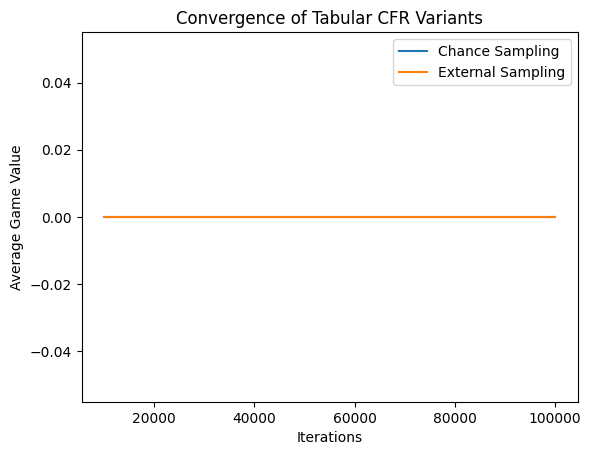

In [4]:
plt.figure()
plt.plot(iters, chance_vals, label='Chance Sampling')
plt.plot(iters, external_vals, label='External Sampling')
plt.xlabel('Iterations')
plt.ylabel('Average Game Value')
plt.title('Convergence of Tabular CFR Variants')
plt.legend()
plt.show()

## Neural Training Loss Curves

Train policies on recorded `logs/game_data/training_data.csv`. Capture epoch losses.

In [ ]:
# Train neural policies and capture losses
# Adjust paths if needed
chance_losses = train_neural(
    'logs/game_data/training_data.csv',
    'logs/game_data/neural_chance.pt'
)
external_losses = train_neural(
    'logs/game_data/training_data.csv',
    'logs/game_data/neural_external.pt'
)

In [ ]:
plt.figure()
plt.plot(range(1, len(chance_losses)+1), chance_losses, label='Neural Chance')
plt.plot(range(1, len(external_losses)+1), external_losses, label='Neural External')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Neural Policy Training Loss')
plt.legend()
plt.show()

## Round-Robin Matches

Let’s have the best three agents play against each other in round-robin fashion and record win rates.

In [ ]:
def play_match(agentA, agentB, rounds=1000):
    wins = { 'A':0, 'B':0, 'draw':0 }
    for _ in range(rounds):
        game = KuhnPokerEngine(agentA, agentB, auto_rounds=1)
        # capture final chips
        game.run_game()
        # simplistic: whoever has more chips wins
        if game.chips[0] > game.chips[1]: wins['A'] += 1
        elif game.chips[1] > game.chips[0]: wins['B'] += 1
        else: wins['draw'] += 1
    return wins

# Instantiate agents
tagents = {
    'Chance_Tabular': CFRAgentChance(),
    'External_Tabular': CFRAgentExternal(),
    'Neural_Chance': NeuralAgent('logs/game_data/neural_chance.pt', input_dim=9)
}
# Round-robin
games = []
labels = list(tagents.keys())
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        a, b = labels[i], labels[j]
        print(f"Playing {a} vs {b}")
        res = play_match(tagents[a], tagents[b], rounds=100)
        games.append((a, b, res))

In [ ]:
# Plotting results
import pandas as pd
records = []
for a,b,res in games:
    records.append({'Match':f'{a} vs {b}', 'A wins':res['A'], 'B wins':res['B'], 'Draws':res['draw']})
df = pd.DataFrame(records).set_index('Match')
df.plot(kind='bar', figsize=(10,6))
plt.title('Round-Robin Win Counts')
plt.show()